In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import seaborn as sns
import cvxopt as opt
from pandas_datareader import data
import yfinance as yf
import sympy
import time
import pyfolio as pf
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Moon\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 구분

In [2]:
#start와 end에 데이터 기간을 정해준다
start = datetime.datetime(2019, 7, 1)
end = datetime.datetime(2020, 12, 1)
#안전자산 : 장기 국채, 중기 국채, 단기 국채, 물가연동국채, 금, 원자재, 달러화, 엔화, 위험자산 후보군 : a_stock, k_stock
# 안전자산 8개, 위험자산 2개 총 10개
a_stock = data.DataReader('VTI', 'yahoo', start, end)
k_stock = data.DataReader('^KS11', 'yahoo', start, end)
l_bond = data.DataReader('TLT', 'yahoo', start, end)
m_bond = data.DataReader('IEI', 'yahoo', start, end)
s_bond = data.DataReader('SHY', 'yahoo', start, end)
tips = data.DataReader('TIP', 'yahoo', start, end)
gold = data.DataReader('GLD', 'yahoo', start, end)
comm = data.DataReader('GSG', 'yahoo', start, end)
dollar = data.DataReader('KRW=X', 'yahoo', start, end)
yen = data.DataReader('JPYKRW=X', 'yahoo', start, end)

In [3]:
a_stock_close = a_stock[['Adj Close']].rename(columns = {'Adj Close':'a_stock_close'})
k_stock_close = k_stock[['Adj Close']].rename(columns = {'Adj Close':'k_stock_close'})
I_bond_close = l_bond[['Adj Close']].rename(columns = {'Adj Close':'l_bond_close'})
m_bond_close = m_bond[['Adj Close']].rename(columns = {'Adj Close':'m_bond_close'})
s_bond_close = s_bond[['Adj Close']].rename(columns = {'Adj Close':'s_bond_close'})
tips_close = tips[['Adj Close']].rename(columns = {'Adj Close':'tips_close'})
gold_close = gold[['Adj Close']].rename(columns = {'Adj Close':'gold_close'})
comm_close = comm[['Adj Close']].rename(columns = {'Adj Close':'comm_close'})
dollar_close = dollar[['Adj Close']].rename(columns = {'Adj Close':'dollar_close'})
yen_close = yen[['Adj Close']].rename(columns = {'Adj Close':'yen_close'})

In [4]:
#Merge the tow tables above (표 병합)
price = pd.concat([a_stock_close,k_stock_close,I_bond_close,m_bond_close,s_bond_close,tips_close ,gold_close,comm_close,dollar_close,yen_close],axis=1)
price.dropna(axis=0)
#Calculate the daily return of individual stock (개별 주식 일별 수익률 계산)
#daily returns = (today price - previous day price)/(previous day price) - 1
pct_ret = np.log(1+price.pct_change()).dropna()
pct_ret = pct_ret.rename(columns={'a_stock_close':'a_stock','k_stock_close':'k_stock','l_bond_close':'I_bond','m_bond_close':'m_bond','s_bond_close':'s_bond','tips_close':'tips','gold_close':'gold','comm_close':'comm','dollar_close' : 'dollar','yen_close' : 'yen'})
log_ret = np.log(price).diff().dropna()
log_ret = log_ret.rename(columns={'a_stock_close':'a_stock','k_stock_close':'k_stock','l_bond_close':'I_bond','m_bond_close':'m_bond','s_bond_close':'s_bond','tips_close':'tips','gold_close':'gold','comm_close':'comm','dollar_close' : 'dollar','yen_close' : 'yen'})
log_ret

,a_stock,k_stock,I_bond,m_bond,s_bond,tips,gold,comm,dollar,yen
Date,,,,,,,,,,
2019-07-02,0.002313,-0.003631,0.007684,0.001752,0.000591,0.000523,0.021135,-0.025122,0.005014,0.010134
2019-07-03,0.007497,-0.012328,0.007104,0.000557,0.000236,0.002612,0.001648,0.010383,0.002819,0.003140
2019-07-09,0.001778,-0.005899,-0.000377,-0.000880,-0.000355,0.001046,0.003498,0.006414,0.001381,-0.000553
2019-07-10,0.004071,0.003284,-0.005522,0.002238,0.001775,0.001741,0.015664,0.027122,-0.005049,0.000461
2019-07-11,0.001375,0.010533,-0.013440,-0.002398,-0.000473,-0.003136,-0.008479,0.001865,-0.001234,-0.003601
...,...,...,...,...,...,...,...,...,...,...
2020-11-23,0.008153,0.019042,-0.004592,-0.000451,0.000000,-0.000795,-0.019890,0.007061,-0.000278,-0.000947
2020-11-24,0.015363,0.005812,-0.010002,-0.000301,0.000116,0.000318,-0.015447,0.020888,-0.000674,-0.006854
2020-11-25,-0.000373,-0.006215,-0.003083,0.000226,0.000116,0.001669,-0.000472,0.007722,-0.003032,-0.002875


In [5]:
price = price.dropna()
price.columns = ['a_stock','k_stock','l_bond','m_bond','s_bond','tips','gold','comm','dollar','yen']

print(price.shape)

(302, 10)


In [6]:
price

,a_stock,k_stock,l_bond,m_bond,s_bond,tips,gold,comm,dollar,yen
Date,,,,,,,,,,
2019-07-01,143.479996,2129.739990,124.356697,120.578163,81.858192,101.522079,130.619995,15.72,1159.750000,10.702000
2019-07-02,143.812225,2122.020020,125.315872,120.789635,81.906570,101.575195,133.410004,15.33,1165.579956,10.811000
2019-07-03,144.894379,2096.020020,126.209244,120.856941,81.925934,101.840889,133.630005,15.49,1168.869995,10.845000
2019-07-08,144.030533,2064.169922,124.704628,120.232170,81.722664,101.548645,131.289993,15.54,1179.849976,10.852000
2019-07-09,144.286850,2052.030029,124.657616,120.126396,81.693649,101.654884,131.750000,15.64,1181.479980,10.846000
...,...,...,...,...,...,...,...,...,...,...
2020-11-24,182.317703,2617.760010,153.201492,130.160843,85.180405,113.324547,169.589996,11.61,1113.079956,10.648019
2020-11-25,182.249664,2601.540039,152.729874,130.190247,85.190262,113.513802,169.509995,11.70,1109.709961,10.617445
2020-11-27,182.891129,2633.449951,154.212067,130.327454,85.190262,113.793129,167.789993,11.69,1105.560059,10.604880


# 시작일로부터 증감률

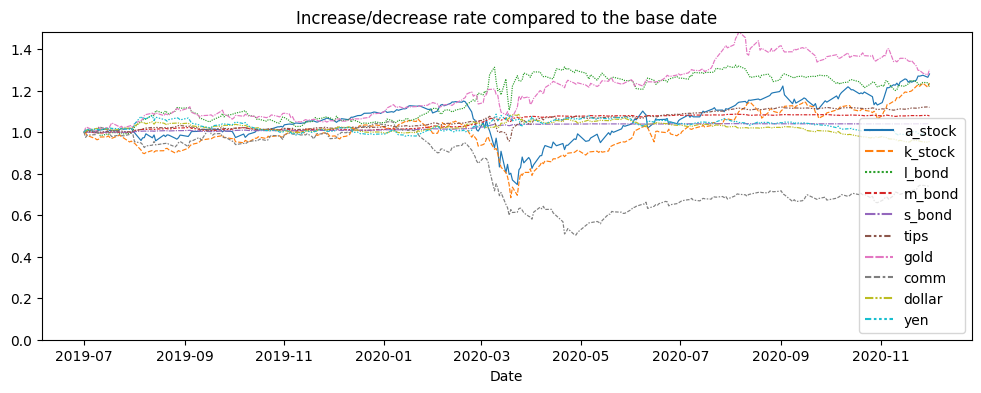

In [7]:
price_rate = price/price.iloc[0] # 기준일(2022-02-23) 대비 증감

plt.figure(figsize=(12,4))
sns.lineplot(data=price_rate, linewidth=0.85)
plt.ylim((0, price_rate.max().max()))
plt.title('Increase/decrease rate compared to the base date')
plt.show()

<AxesSubplot: title={'center': "Correlation of all asset's percent change"}>

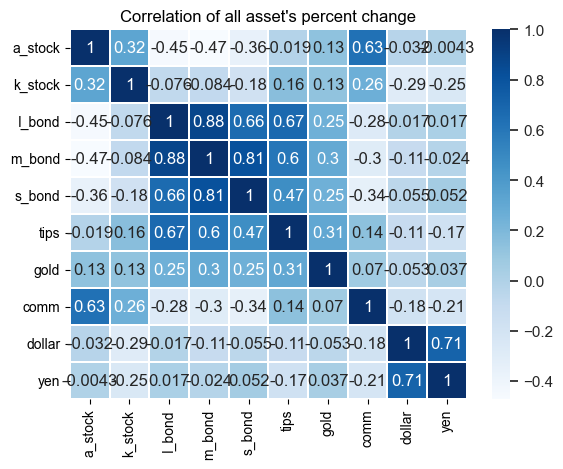

In [8]:
# 일일 수익률 간 상관관계 시각화

plt.title("Correlation of all asset's percent change")
sns.set(rc = {'figure.figsize':(12,10)})
sns.heatmap(log_ret.corr(), cmap='Blues', linewidth=0.2, annot=True)

# 안전자산 비중 설정

In [9]:
#Generate random weights (무작위 가중치 생성)

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

# 포트폴리오 최적화

In [10]:
port_ratios = []

# 주식의 일별 및 총 기간 수익을 계산
returns_annual = log_ret.mean() * 252

# 주식 수익의 일별 및 공분산을 계산
cov_daily = log_ret.cov()
cov_annual = cov_daily * 252

# 포트폴리오의 수익률, 변동성 및 가중치를 저장하기 위한 빈 리스트
port_returns = np.array([])
port_volatility = np.array([])
sharpe_ratio = np.array([])
stock_weights = []

# N개의 무작위 포트폴리오 생성 (300000개)
num_assets = len(price.columns)
num_portfolios = 300000

# 빈 리스트를 각 포트폴리오의 수익률, 변동성 및 가중치로 채워줍니다.
for single_portfolio in range(num_portfolios):
    weights = rand_weights(len(price.columns))
    port_ratios.append(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio = np.append(sharpe_ratio, sharpe)
    port_returns = np.append(port_returns, returns)
    port_volatility = np.append(port_volatility, volatility)
    stock_weights.append(weights)
    count+= 1
    print(count)

# 각 포트폴리오의 수익률 및 리스크를 사전정리
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

for counter,symbol in enumerate(price.columns):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# 포트폴리오를 DataFrame 형태로 만들어준다.
df = pd.DataFrame(portfolio)

column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in price.columns]

# DataFrame columns 재정의
df = df[column_order]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_29280\1797604996.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


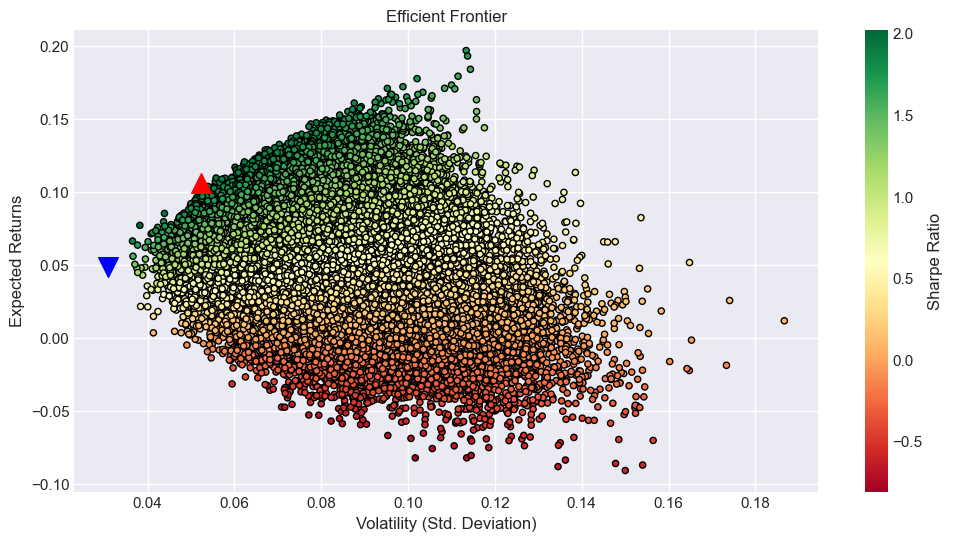

In [11]:
# DataFrame에서 최소 변동성 및 최대 샤프지수 값 찾기(df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# 최소 변동성 값, 최대 샤프지수 값을 사용하여 두 개의 특수 포트폴리오를 찾고 생성합니다.
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# Efficient Frontier(Minimum-variance), max sharpe & min Volatility values를 scatterplot을 이용하여 시각화
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(12, 6), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='^', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='v', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

# 샤프지수에 따른 포트폴리오 비율 시각화

In [12]:
sorted_shape_idx2 = np.argsort(sharpe_ratio)
sorted_risk_idx2 = np.argsort(port_volatility)

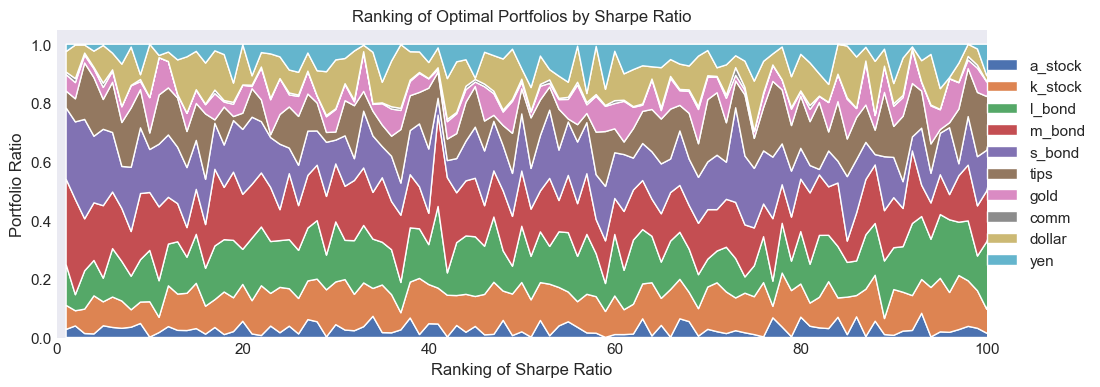

In [13]:
#샤프지수가 높은 상위 100개 포트폴리오 비율
port_df = pd.DataFrame(port_ratios)
sorted_port_df2 = port_df.iloc[sorted_shape_idx2[::-1]] # 역순
sorted_port_df2.columns = price.columns

plt.figure(figsize=(12,4))
plt.stackplot(np.arange(1,len(sorted_port_df2)+1,1), np.array(sorted_port_df2.T), labels=sorted_port_df2.columns)

plt.xlim(0,100)
plt.legend(bbox_to_anchor=(1.12,0.95))
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Portfolio Ratio')
plt.title('Ranking of Optimal Portfolios by Sharpe Ratio')
plt.show()

# 샤프 지수에 따른 포트폴리오 수익률 및 변동성

In [14]:
# print the details of the 2 special portfolios
print(f'최소 위험도 포트폴리오 비율 : \n {min_variance_port.T}')
print(f'최적의 포트폴리오 비율 : \n {sharpe_portfolio.T}')

최소 위험도 포트폴리오 비율 : 
                      550
Returns         0.048179
Volatility      0.030850
Sharpe Ratio    1.561700
a_stock Weight  0.002861
k_stock Weight  0.042642
l_bond Weight   0.018006
m_bond Weight   0.251407
s_bond Weight   0.298786
tips Weight     0.027699
gold Weight     0.061603
comm Weight     0.032113
dollar Weight   0.251299
yen Weight      0.013585
최적의 포트폴리오 비율 : 
                    83490
Returns         0.105800
Volatility      0.052335
Sharpe Ratio    2.021588
a_stock Weight  0.027566
k_stock Weight  0.082174
l_bond Weight   0.139313
m_bond Weight   0.291130
s_bond Weight   0.242769
tips Weight     0.057373
gold Weight     0.056421
comm Weight     0.008418
dollar Weight   0.069479
yen Weight      0.025358
